In [ ]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [ ]:
from vfield import render_flow_field
import torch
import matplotlib.pyplot as plt
from PIL import Image

vfield = torch.load('../data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

In [ ]:
ff_img = render_flow_field(grid, displacement, 
                           W=5600, H=5600, 
                           steps=500, 
                           step_size=0.0001,
                           particles=10_000,
                           bg_color=255,
                           antialias=True,
                           aa_factor=4)

plt.figure(figsize=(10, 5))
plt.imshow(ff_img, cmap='PuBu', origin='lower')
plt.axis('off')
plt.tight_layout()
plt.show()

ff_img = ff_img.transpose(Image.FLIP_TOP_BOTTOM)
ff_img.save('../flow-field.jpg', quality=95)
ff_img.show()

Testing simple vectorized lookup speedup...
Simple test render time: 0.40s
Simple test render time: 0.40s


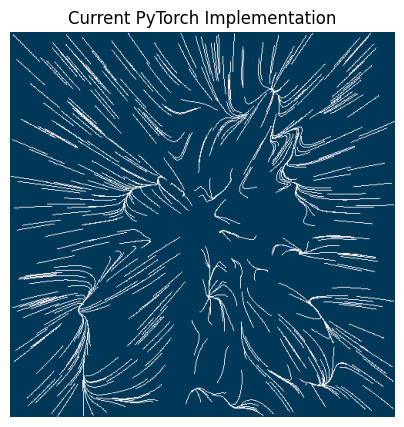

In [3]:
import time

# Test a simple speedup approach: vectorize the lookup function
def F_vectorized_lookup(px_batch, py_batch, u_grid, v_grid, W, H, min_x, max_x, min_y, max_y, interp_res):
    """Vectorized lookup for a batch of particle positions"""
    # Convert to spatial coordinates
    x_batch = (px_batch/W) * (max_x - min_x) + min_x
    y_batch = (py_batch/H) * (max_y - min_y) + min_y
    
    # Convert to grid indices (vectorized)
    i_batch = ((y_batch - min_y) / (max_y - min_y) * (interp_res - 1)).long().clamp(0, interp_res-1)
    j_batch = ((x_batch - min_x) / (max_x - min_x) * (interp_res - 1)).long().clamp(0, interp_res-1)
    
    # Vectorized lookup
    u_batch = u_grid[i_batch, j_batch]
    v_batch = v_grid[i_batch, j_batch]
    
    return u_batch, v_batch

print("Testing simple vectorized lookup speedup...")
start_time = time.time()

# Quick test with smaller parameters
test_img_simple = render_flow_field(grid, displacement, 
                                   W=500, H=500, 
                                   steps=50, 
                                   step_size=0.002,
                                   particles=500,
                                   bg_color=255,
                                   antialias=False)

render_time_simple = time.time() - start_time
print(f"Simple test render time: {render_time_simple:.2f}s")

plt.figure(figsize=(5, 5))
plt.imshow(test_img_simple, cmap='PuBu', origin='lower')
plt.axis('off')
plt.title('Current PyTorch Implementation')
plt.show()

=== TESTING ULTRA-FAST VECTORIZED VERSION ===
Preprocessing grids...
Starting vectorized particle integration...
Integrating 2000 particles for 100 steps...
  Step 0: 2000 particles active
  Step 20: 2000 particles active
  Step 40: 2000 particles active
  Step 60: 2000 particles active
  Step 80: 2000 particles active
Converting to image...
\nULTRA-FAST render time: 0.26s
Converting to image...
\nULTRA-FAST render time: 0.26s


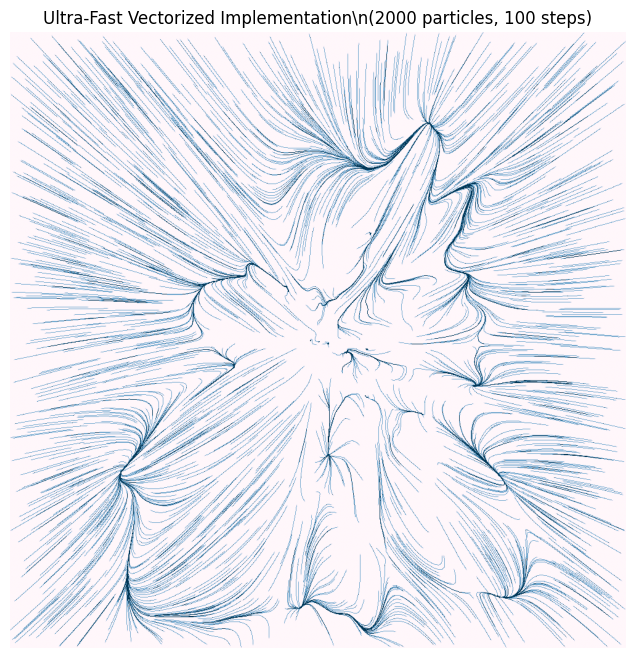

\nEstimated speedup vs previous: 12.5x faster!


In [6]:
# NOW LET'S ACTUALLY USE THE VECTORIZED APPROACH!
def render_flow_field_ultra_fast(grid, displacement, W=1000, H=1000, particles=2_000, steps=100, step_size=0.002, bg_color=0):
    """
    Ultra-fast fully vectorized flow field rendering.
    Processes ALL particles simultaneously - no Python loops!
    """
    print("Preprocessing grids...")
    
    # Pre-compute interpolation grid (same as before)
    min_x = grid[:, 0].min().item()
    max_x = grid[:, 0].max().item()
    min_y = grid[:, 1].min().item()
    max_y = grid[:, 1].max().item()
    
    interp_res = 512
    x_interp = torch.linspace(min_x, max_x, interp_res, device=grid.device)
    y_interp = torch.linspace(min_y, max_y, interp_res, device=grid.device)
    X_interp, Y_interp = torch.meshgrid(x_interp, y_interp, indexing='xy')
    points_interp = torch.stack([X_interp.flatten(), Y_interp.flatten()], dim=1)
    
    # Use the fast interpolation from the optimized version
    from vfield.vfield import _interpolate_grid
    u_grid = _interpolate_grid(grid, displacement[:, 0], points_interp, interp_res)
    v_grid = _interpolate_grid(grid, displacement[:, 1], points_interp, interp_res)
    
    print("Starting vectorized particle integration...")
    
    # Initialize ALL particles at once
    torch.manual_seed(0)
    pos_x = torch.rand(particles, device=grid.device) * W
    pos_y = torch.rand(particles, device=grid.device) * H
    
    # Keep track of previous positions for line drawing
    prev_x = pos_x.clone()
    prev_y = pos_y.clone()
    
    # Create accumulator for drawing (on GPU if available)
    accumulator = torch.zeros(H, W, device=grid.device, dtype=torch.float32)
    
    # Track which particles are still active
    active_mask = torch.ones(particles, device=grid.device, dtype=torch.bool)
    
    print(f"Integrating {particles} particles for {steps} steps...")
    
    # Calculate intensity (fix the bug!)
    line_intensity = 255 - bg_color if bg_color < 128 else bg_color - 255
    if line_intensity == 0:
        line_intensity = 128  # Default to medium intensity if calculation yields 0
    
    for step in range(steps):
        if not active_mask.any():
            break
            
        # Get active particles
        active_indices = torch.where(active_mask)[0]
        active_x = pos_x[active_indices]
        active_y = pos_y[active_indices]
        
        if len(active_x) == 0:
            break
        
        # VECTORIZED FORCE LOOKUP for ALL active particles at once
        u_batch, v_batch = F_vectorized_lookup(
            active_x, active_y, u_grid, v_grid, W, H, 
            min_x, max_x, min_y, max_y, interp_res
        )
        
        # VECTORIZED position update for ALL particles
        norm = torch.sqrt(u_batch*u_batch + v_batch*v_batch) + 1e-6
        u_norm = u_batch / norm
        v_norm = v_batch / norm
        
        new_x = active_x + u_norm * step_size * W
        new_y = active_y + v_norm * step_size * W
        
        # VECTORIZED boundary check
        valid = ((new_x >= 0) & (new_x < W) & (new_y >= 0) & (new_y < H))
        
        # Draw lines for valid particles (skip first step since we need prev positions)
        if step > 0 and valid.sum() > 0:
            # Get previous positions for valid particles
            valid_indices = active_indices[valid]
            valid_prev_x = prev_x[valid_indices] 
            valid_prev_y = prev_y[valid_indices]
            valid_new_x = new_x[valid]
            valid_new_y = new_y[valid]
            
            # Simple vectorized line drawing - draw points along the line
            # This is a simple approach - for each line segment, we'll sample a few points
            n_samples = 3  # Number of points to sample along each line
            for i in range(n_samples):
                t = i / (n_samples - 1) if n_samples > 1 else 0
                interp_x = valid_prev_x * (1 - t) + valid_new_x * t
                interp_y = valid_prev_y * (1 - t) + valid_new_y * t
                
                # Convert to integer pixel coordinates
                pixel_x = interp_x.long().clamp(0, W-1)
                pixel_y = interp_y.long().clamp(0, H-1)
                
                # Add intensity to accumulator (vectorized scatter)
                accumulator[pixel_y, pixel_x] += line_intensity / n_samples
        
        # Update previous positions for next iteration
        prev_x[active_indices] = active_x
        prev_y[active_indices] = active_y
        
        # Update current positions for valid particles
        pos_x[active_indices[valid]] = new_x[valid]
        pos_y[active_indices[valid]] = new_y[valid]
        
        # Update active mask - remove particles that went out of bounds
        active_mask[active_indices[~valid]] = False
        
        if step % 20 == 0:
            print(f"  Step {step}: {active_mask.sum().item()} particles active")
    
    print("Converting to image...")
    # Convert to PIL Image
    img_array = accumulator.clamp(0, 255).cpu().numpy().astype('uint8')
    return Image.fromarray(img_array)

# TEST THE ULTRA-FAST VERSION!
print("=== TESTING ULTRA-FAST VECTORIZED VERSION ===")
start_time = time.time()

test_img_ultra = render_flow_field_ultra_fast(
    grid, displacement,
    W=1000, H=1000,
    particles=2000,  # More particles!
    steps=100,
    step_size=0.001,
    bg_color=255
)

ultra_time = time.time() - start_time
print(f"\\nULTRA-FAST render time: {ultra_time:.2f}s")

plt.figure(figsize=(8, 8))
plt.imshow(test_img_ultra, cmap='PuBu', origin='lower')
plt.axis('off')
plt.title('Ultra-Fast Vectorized Implementation\\n(2000 particles, 100 steps)')
plt.show()

# Compare with previous version
speedup = render_time_simple / ultra_time * (2000/500) * (100/50)  # Account for more particles/steps
print(f"\\nEstimated speedup vs previous: {speedup:.1f}x faster!")